# はじめに

この資料では、ディープラーニングの手法を用いて、手書き数字の画像データの分類問題に取り組みます。

ディープラーニングとは、脳の学習機能をコンピュータ上で模した（ディープ）ニューラルネットワークを用いた機械学習手法です。

以下では、先ずニューラルネットワークについて学習し、その後、Googleが開発したTensorFlowのラッパーライブラリであるKerasを用いてモデルを構築し、学習と推論を行います。





# 準備

## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


＊以下のパスは適宜修正してください。

In [ ]:
cd drive/MyDrive/Colab Notebooks/AIPG/DL

[Errno 2] No such file or directory: 'drive/MyDrive/TKAI/AIPG/DL'
/content/drive/MyDrive/TKAI/AIPG/DL


In [ ]:
ls

Deap_learning.ipynb  Deap_learning_old.ipynb  fig/


## ライブラリをインストール

Matplotlibの日本語化ライブラリをインストール

In [ ]:
pip install japanize-matplotlib

## ライブラリをインポート

In [ ]:
# 画像表示用のライブラリ
from IPython.display import Image

# 数値計算用のライブラリ
import numpy as np

# 画像描画用のライブラリ
import matplotlib.pyplot as plt
# Matplotlibの日本語化ライブラリ
import japanize_matplotlib

# Matplotlibのインライン表示用のおまじない
%matplotlib inline


# ディープラーニングとは

冒頭でも述べた通り、ディープラーニングで用いるニューラルネットワークは、人間の脳の学習機能をコンピュータ上で模したモデルです。

そこで、以下では先ず初めに、人間の脳、特に脳細胞の特徴について学習します。

## ニューロン

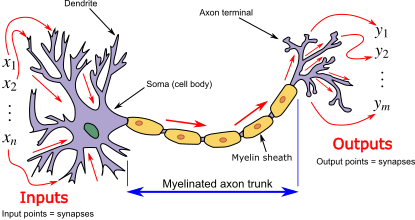

In [ ]:
# 画像を表示
Image('fig/Neuron3.png', width=600)

人間の大脳には数百億の神経細胞（ニューロン）があり、これらニューロンが複雑なネットワークを構成して、情報の伝達と処理を行うことで、高度な機能を獲得していると考えられています。

ニューロンには、樹状突起(Dendrite)と呼ばれる構造（図の左）があり、この部分を通じて、他のニューロンから電気信号を受け取ります。そして、受け取った電気信号がある一定の値（閾値）以上になると、軸索(Axon)という構造（図の右）を通じて、次のニューロンに電気信号を伝達します。

ここで重要なのが、軸索と樹状突起の先端に位置する、シナプス（Synapse）と呼ばれる信号伝達を行う部位で、このシナプス結合の強さによって、あるニューロンが発した電気信号が、次のニューロンに伝わる強さが決まります。

私たちの脳は、さまざまなニューロンのシナプス伝達強度を変化させることで、様々なタイプの学習と処理をおこなっています。


## 人口ニューロンモデル

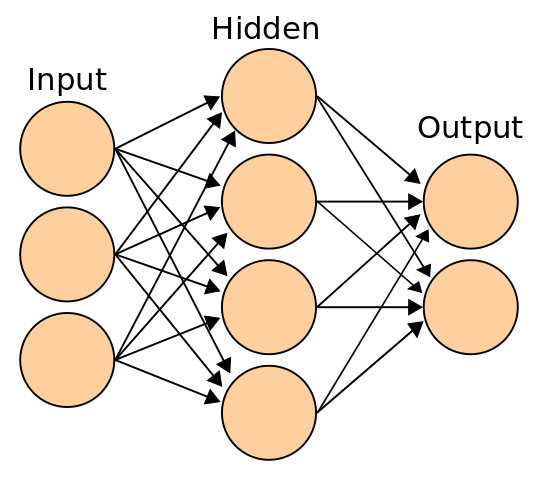

In [ ]:
Image('fig/538px-Artificial_neural_network.png', width=600)

このニューロンの機能をコンピュータ上で再現したものが、人口ニューロンになります。

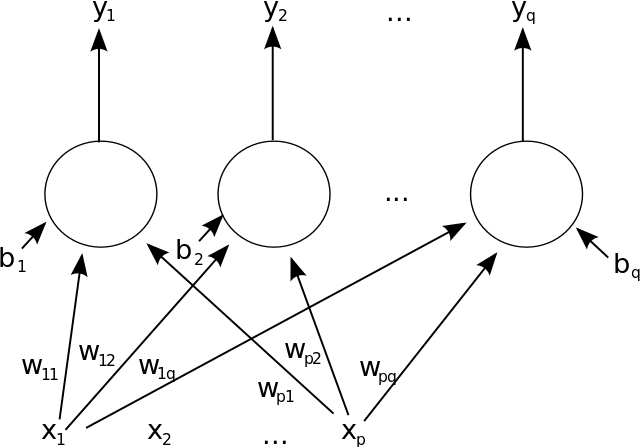

In [ ]:
Image('fig/640px-Single_layer_ann.png', width=600)

上図において、$x_1$から$x_p$は、1番からp番のニューロンが発した電気信号の強さになります。

これらの信号を次のニューロン（上図の各○）がどのように受け取るかを計算する際には、前述のニューロン間のシナプス結合の強さに対応する、重み$w$を各$x$に掛け合わせます。

例えば、図の1番左のニューロンが受け取る電気信号の強さは、次の式で表されます。

$a_1= x_1w_{11} + x_2 w_{21} + \dots + x_p w_{p1} + b_1$

同様に、左から2番目のニューロンが受け取る電気信号の強さは、次の式で表されます。

$a_2= x_1w_{12} + x_2 w_{22} + \dots + x_p w_{p2} + b_2$

ここで、式の末尾に足されている$b_1$と$b_2$はバイアスと呼ばれる項で、そのニューロン自体の発火のしやすさを表します。

最後に、前述の閾値に対応して、活性化関数と呼ばれる関数を用いて、各$a$の値を変換し、変換後の値をそのニューロンの出力値とします。

なお、活性化関数として有名なものには、シグモイド関数やReLU (Rectified Linear Unit)関数があり、それぞれ以下のような形をしています。

### シグモイド関数

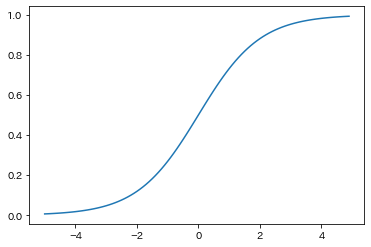

In [ ]:
a = np.arange(-5,5,0.1)
plt.plot(a, 1/(1+np.exp(-a)))

図から分かる通り、シグモイド関数は$a$の値を0から1の範囲になめらかに変換します。$a$の値がゼロよりも小さくなればなるほど出力は0に近づき、逆に$a$の値がゼロよりも大きくなればなるほど出力は1に近づきます。

### ReLU関数

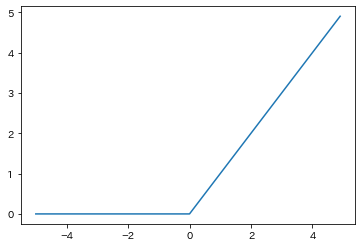

In [ ]:
a = np.arange(-5,5,0.1)
plt.plot(a, np.maximum(0,a))

図から分かる通り、ReLU関数は$a$が正の範囲で出力が入力に比例します。また、$a$の負の範囲で出力は0になります。

## ニューラルネットワーク

上述のような人口ニューロンを複数組み合わせ、層を重ねたものが、ニューラルネットワークと呼ばれるものになります。

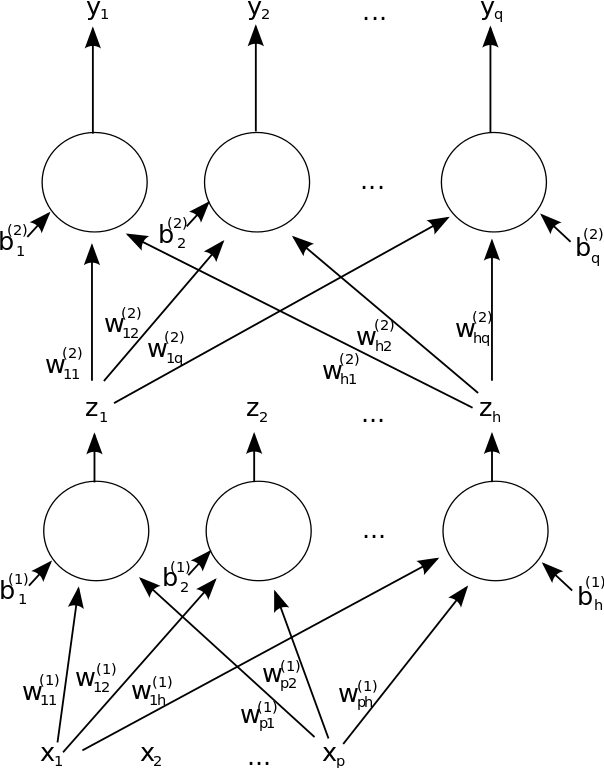

In [ ]:
Image('fig/604px-Two_layer_ann.png', width=600)

本資料では、TensorFlowのラッパーライブラリであるKerasを使用して、このようなニューラルネットワークを構築し、手書き数字の画像データに書かれた数字を推論する分類器を作成します。

この場合、入力の$x_1$から$x_p$は、目の網膜細胞一つ一つが受け取る光の強さに対応します。また、$y_1$から$y_{q(=10)}$は、0から9の各数字に反応するニューロンに対応します。

# MNISTデータセット

今回の学習で使用するデータは、MNISTデータベース[(THE MNIST DATABASE of handwritten digits)](http://yann.lecun.com/exdb/mnist/)の手書き数字画像になります。このデータセットは、各種ベンチマークで多用される、大変ポピュラーなデータセットです。

後ほど詳しくみますが、このデータセットは以下のような画像データと正解ラベルで構成されています。

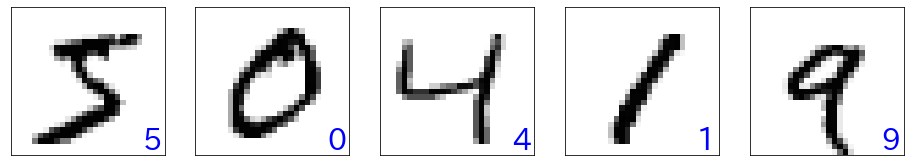

In [ ]:
Image('fig/MNIST.png', width=600)

## データセットの概要

それでは、データセットをロードして内容を確認してみましょう。

In [ ]:
# KerasからMNISTデータセットをインポート


# データセットをロード


このデータセットは、6万枚の訓練用画像とその正解ラベルデータ、1万枚のテスト用画像とその正解ラベルデータから構成されています。

また、各画像は28ピクセル×28ピクセルで構成されています。

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

各ピクセルのデータは、0から255までの値(256通り＝1バイト）を取る数値データになっています。この値は、人間の目の網膜細胞が受け取る光の刺激の強さに対応します。そして、これらの値の集合によって、全体として、先ほど見た図のような、一枚一枚の白黒画像がつくられます。


In [ ]:
# ピクセル値の最小値、最大値、平均値


array([  0.  , 255.  ,  33.32])

実際に、訓練データの1枚目の画像データの10行目の値をみてみましょう。

In [ ]:
# 一枚目のデータの10行目を表示


array([  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
       205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

次に、各画像に付随する、正解ラベル（教師データ）についてみてみましょう。このデータは、0から9までの十通りの値を取ります。

各数字で画像の枚数にばらつきがありますが、概ね均等に用意されています。

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

array([[   0,  980],
       [   1, 1135],
       [   2, 1032],
       [   3, 1010],
       [   4,  982],
       [   5,  892],
       [   6,  958],
       [   7, 1028],
       [   8,  974],
       [   9, 1009]])

実際に、訓練データの1枚目の画像データの正解ラベルの値をみてみましょう。

一枚目の画像のラベルは「5」です。

5

## 訓練データの図示

それでは、画像データを図示してみましょう。

以下では、Matplotlibを使用して、訓練データの最初の五枚の画像を表示してみます。

<Figure size 432x288 with 0 Axes>

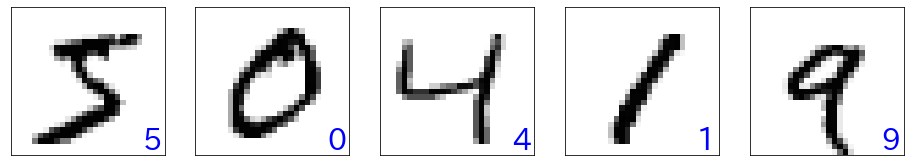

In [ ]:
# カラーマップをgrayに設定


# 1行5列のAxesを持つFigureを生成




  # i番目の画像データを取得

  # データを(白黒を反転して)描画

  # 正解ラベルを表示

  # y軸を反転

  # x軸に関する情報を非表示

  # y軸に関する情報を非表示

  # アスペクト比を合わせる


# 結果を表示


# ディープラーニング

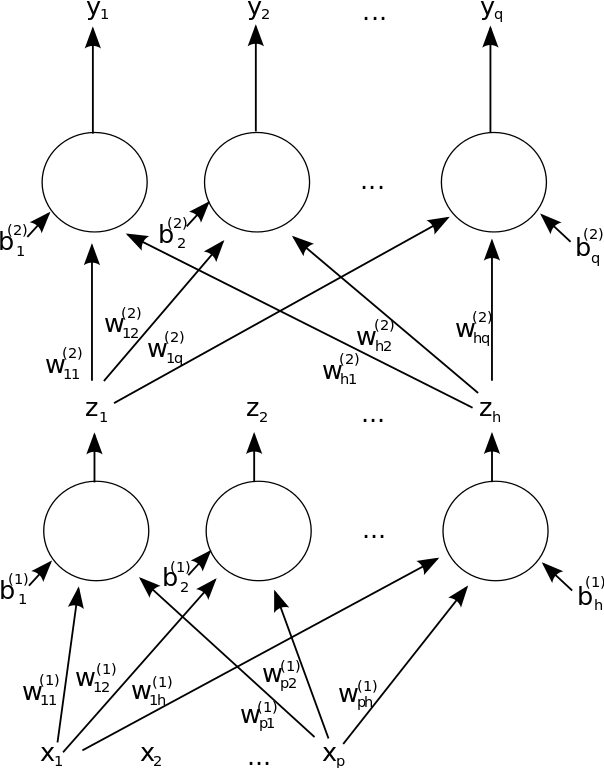

In [ ]:
Image('fig/604px-Two_layer_ann.png', width=600)

ここからは、上図のような2層のニューラルネットワークを構築して、モデルの学習と推論を行います。

ここで、入力層の出力に対応する$x_1$から$x_p$は、目の網膜細胞一つ一つが受け取る光の強さに対応すると述べましたが、MNISTの画像データは28ピクセル×28ピクセルで構成されているので、p=784(=28×28)と設定します。

次に、中間層の出力は$z_1$から$z_h$になりますが、以下では$h=16$、つまり16個のニューロンを用意します。（この数字は自由に変えてみてください。）

最後に、出力層の出力は$y_1$から$y_q$になりますが、今回は0から9の計10種類の数字を見分けることから、$q=10$とします。

目標は、0と書かれた画像が入力された際には、$y_0$のみ1（に近い値）を出力し、その他の$y$は0（に近い値）を出力、1と書かれた画像が入力された際には、$y_1$のみ1（に近い値）を出力し、その他の$y$は0（に近い値）を出力というように、入力された数に対応する$y$のみが発火するように、ネットワークの重み$w_{ij}$を学習することです。

因みに、最後の出力層にはソフトマックス関数という活性化関数を用います。この関数を用いると、ある入力に対する各出力$y_i$の和は常に1となることから、各$y_i$の値は、入力画像の数字がiである確率を表すことになります。

### データの前処理

はじめに、画像データに対して以下のような前処理を行います。

- 28×28のピクセルデータを、長さ(28×28＝)784の一列のピクセルデータの配列に変形します。

- ピクセルデータの値を浮動小数点型に変換します。

- ピクセルデータの値を、0以上1以下の値に規格化します。

- 正解ラベルをone-hotエンコーディングします。


In [ ]:
# Numpy関連のユーティリティモジュールをインポート


# 前処理用の関数を定義

  
  # 画像データ（の画像部分）を１次元配列に整形


  # ピクセルデータを浮動小数点数型に型変換


  # ピクセルデータの範囲を0〜1に規格化


  # 正解ラベルをone-hotエンコーディング




# 訓練データに対して前処理を実行


# テストデータに対して前処理を実行


実行結果を確認してみましょう。

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

画像データが一列に直列化されました。

実際に、訓練データの1枚目の画像データの10「行目」の値をみてみましょう。

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3137255 , 0.6117647 ,
       0.41960785, 0.99215686, 0.99215686, 0.8039216 , 0.04313726,
       0.        , 0.16862746, 0.6039216 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

ピクセル値は０以上1以下の値に収まっています。

次に、訓練データの1枚目の画像データの正解ラベルの値をみてみましょう。

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

正しく、6番目の要素（0はじまりなので、5に対応）にだけ1が立ちました。

## ネットワークの作成

ここでは、2層のニューラルネットワークを以下の流れで作成します。

- 学習結果の再現性を確保するために、計算過程で使用する乱数のシード値を任意の値で固定します。

- Sequentialクラスをインスタンス化し、系列モデルを作成します。

- モデルに中間層を(クラスをインスタンス化して)を追加します。
  - 16は中間層のユニット（ニューロン）数です。
  - ``input_dim``は入力次元で、今回は28×28の784になります。
  - ``activation``は活性化関数で、今回はシグモイド関数を使用します。

- モデルに出力層を(クラスをインスタンス化して)を追加します。
  - 10は出力層のユニット（ニューロン）数です。
  - ``input_dim``は特に指定しません。＊16と自動で認識されます。
  - ``activation``は活性化関数で、ソフトマックス関数を使用します。

- 訓練プロセスを設定します。
  - ``loss``は損失関数と呼ばれるもので、モデルが重みを学習する際に指標とする、予測と正解との乖離具合を計算する関数です。今回は交差エントロピーと呼ばれるものを指定します。
  - ``optimizer``は重みを最適化する際に使用するアルゴリズムのことで、今回はAdam (Adaptive moment estimator)クラスを使用します。
  - ``metrics``は評価指標のことで、今回はaccuracy(正解率)を使用します。

In [ ]:
# 乱数シード値を固定


#　系列モデルをインポート


# 全結合層用のクラスをインポート


# 最適化アルゴリズムとしてAdamをインポート


# 系列モデルをインスタンス化


# モデルに（中間）層を追加


# モデルに（出力）層を追加


# 学習プロセスを設定


作成したモデルを確認してみましょう。

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                12560     
                                                                 
 dense_6 (Dense)             (None, 10)                170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


パラメータ数を検算しましょう。

784個の入力層のニューロンと中間層の16個のニューロンをつなぐ重みの数、それにバイアス項を加えた数、中間層の16個のニューロンと出力層の10個のニューロンをつなぐ重みの数、それにバイアス項を加えた数を計算しています。

(12544, 12560, 160, 170)

## 学習

前節で作成したモデルのfit()メソッドを実行することで、モデルの学習を行います。

引数の内容は以下の通りです。

- ``x_train``: 訓練データ
- ``y_train``: 教師ラベル
- ``epochs``: 同一の訓練データをモデルに何回見せるか。今回は10とします。
- ``batch_size``: 一度に何枚の画像で損失関数の計算と重みの更新を行うか。今回は1000とします。
- ``verbose``: 学習の進捗の表示設定。今回は1とします。
- ``validation_data``: 検証データ。今回は``x_test``と``y_test``を使用します。＊本来は訓練データを学習用と検証用に分けます。

学習を実行すると、メソッドの戻り値としてHistoryインスタンスが返ってきます。



In [ ]:
# 学習を実行


Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 1.9796 - accuracy: 0.4869 - val_loss: 1.6758 - val_accuracy: 0.7508
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5069 - accuracy: 0.7811 - val_loss: 1.3238 - val_accuracy: 0.8235
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2164 - accuracy: 0.8273 - val_loss: 1.0847 - val_accuracy: 0.8496
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0120 - accuracy: 0.8476 - val_loss: 0.9136 - val_accuracy: 0.8651
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8636 - accuracy: 0.8609 - val_loss: 0.7893 - val_accuracy: 0.8735
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7540 - accuracy: 0.8701 - val_loss: 0.6960 - val_accuracy: 0.8780
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6712 - accuracy: 0.8762 - val_loss: 0.6259 - val_accuracy: 0.8846
Epoch 8/10
60/60 [==

## 予測結果と評価指標

最適な重みを学習したモデルを使用して、学習データとは異なるテストデータを用いて、予測の評価を行います。

In [ ]:
# モデルをテストデータで評価


# 誤差の表示


# 正答率の表示


Loss: 0.49207
Accuracy: 0.8945


Lossは交差エントロピーを使用した予測と正解の乖離具合を表し、Accuracyは正解率を表します。
（なお、今回は学習時の検証データとしてここで用いたテストデータを使用しているので、同じ値がEpoch 10の``val_loss``と``val_accuracy``にも現れます。）

今回のテストデータは全部で10000枚なので、10000に正解率を掛けると正解した枚数が、その数を10000から引くと予測を誤った枚数が求まります。

（正解した枚数はおよそ9000枚、不正解だった枚数がおよそ1000枚になっていることでしょう。）




## Historyオブジェクト

モデルの学習過程は、Historyオブジェクトに格納されています。フィールドを確認してみましょう。

dict_keys(['validation_data', 'model', '_chief_worker_only', '_supports_tf_logs', 'history', 'params', 'epoch'])

``params``という辞書型の変数には、``fit``メソッドで指定した``epochs``と``verbose``の値に加えて、各エポック内でのパラメータ更新の回数であるステップ数（60000レコードをバッチサイズ1000で学習したので、60000÷1000＝60）が格納されています。

{'epochs': 10, 'steps': 60, 'verbose': 1}

``history``と言う辞書型の変数には、学習過程の``loss``と``accuracy``の推移が、訓練データと検証データに分けて格納されています。

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

[1.9796288013458252,
 1.5068836212158203,
 1.216436743736267,
 1.0120104551315308,
 0.8636406064033508,
 0.7540280818939209,
 0.6712037324905396,
 0.6075202226638794,
 0.5573165416717529,
 0.5168727040290833]

[0.48686665296554565,
 0.781083345413208,
 0.8272500038146973,
 0.8476166725158691,
 0.8608666658401489,
 0.8700833320617676,
 0.8761666417121887,
 0.8824999928474426,
 0.8875333070755005,
 0.8922666907310486]

[1.6758394241333008,
 1.3237849473953247,
 1.084708571434021,
 0.9135909080505371,
 0.7892636060714722,
 0.6960063576698303,
 0.6259233355522156,
 0.5709261298179626,
 0.5278090238571167,
 0.4920697808265686]

[0.7508000135421753,
 0.8234999775886536,
 0.8496000170707703,
 0.8651000261306763,
 0.8734999895095825,
 0.878000020980835,
 0.8845999836921692,
 0.8892999887466431,
 0.8921999931335449,
 0.8945000171661377]

この情報を用いて、学習の推移をプロットしてみましょう。

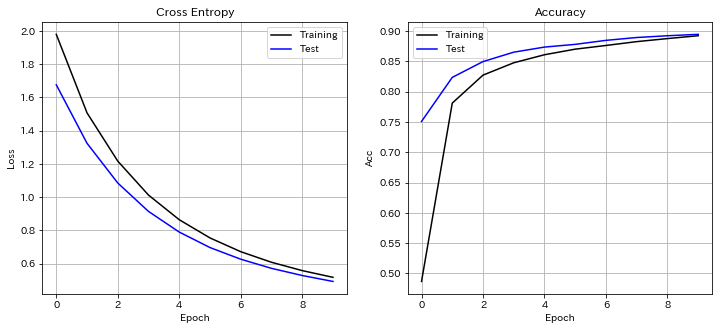

In [ ]:
# 1行2列のAxesを持つFigureを生成


# 1番目のAxesに訓練データに対するLossを描画

# 1番目のAxesに検証データに対するLossを描画

# 1番目のAxesのタイトルを設定

# 1番目のAxesのy軸ラベルを設定


# 2番目のAxesに訓練データに対するAccuracyを描画

# 2番目のAxesに検証データに対するAccuracyを描画

# 2番目のAxesのタイトルを設定

# 2番目のAxesのy軸ラベルを設定


# Axesに対する共通処理を設定

  # 凡例を表示

  # x軸ラベルを設定

  # グリッドを表示


# 図を表示


グラフから、訓練データと検証データの両方において、Epochが進むごとに損失関数の値が減少し、正解率が上昇していることが確認できます。また、二つのグラフが大きく乖離し出すことはなく、過学習は起きていないと言えます。

## モデルの予測結果の図示

この節では、テストデータの画像と、テストデータに対するモデルの予測値を同時に表示して、モデルの精度を可視化してみます。

In [ ]:
# 予測結果を描画する関数


  # 表示する画像の枚数


  # モデルの予測を取得


  # カラーマップをgrayに設定


  # 10行10列のAxesを持つFigureを生成


  # Figureのタイトルを設定

  
  # Figureのタイトルの位置を調節


  # ループ処理の開始


    # 行の値を指定

    # 列の値を指定


    # 画像データを取得


    # 画像データを整形


    # データを（白黒を反転して）描画


    # （one-hotエンコーディングされている）予測ラベルの取り出し


    # 確率がもっとも高いインデックスを取得


    # 正解ラベルのインデックスを取得


    # 予測値の文字色を正解した場合には黒、誤った場合には赤に設定


    # 予測値を表示


    # 予測と正解が異なる場合


      # Axesの上部にバーを表示

    
    # 縦軸の表示範囲を（反転して）設定

 
     # x軸に関する情報を非表示


    # y軸に関する情報を非表示

    
    # アスペクト比を揃える


  # 結果を表示


<Figure size 432x288 with 0 Axes>

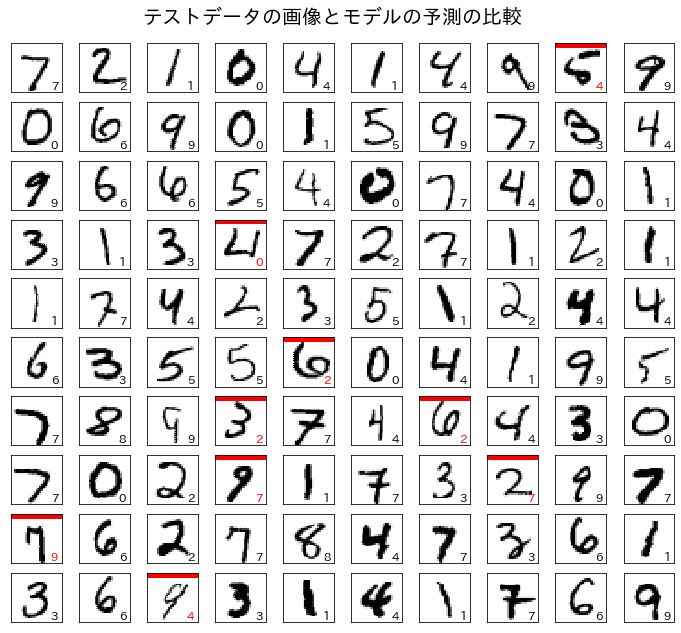

In [ ]:
# show_prediction関数の実行
show_prediction()

上の図から、モデルがどのような入力に対して推論を誤ったかがみてとれます。

後のモデルでこれがどのように改善されるか注目しましょう。

## 重みを図示

この章の最後に、モデルが学習した重みについてみてみましょう。

モデルの重みパラメータは、2つの``numpy``配列を含むリストで構成されています。

(2, (784, 16), (16,))

(2, (16, 10), (10,))

重みの値の統計量を見てみます。

,count,mean,std,min,25%,50%,75%,max
0,12544.0,0.001314,0.172843,-0.61113,-0.121717,0.003253,0.125394,0.608817


,count,mean,std,min,25%,50%,75%,max
0,16.0,0.001773,0.227284,-0.369315,-0.156476,0.065343,0.175631,0.340544


中間層の重みを図示してみましょう。

In [ ]:
# 重みを描画する関数


  # カラーマップをgrayに設定


  # 2行8列のAxesを持つFigureを生成


  # Figureのタイトルを設定


  # Figureのタイトルの位置を調節


  #　中間層の重みを取得


  # ループ処理を開始


    # 行の値を指定


    # 列の値を指定


    # 重みデータを取得


    # 重みデータを整形


    # 重みを表示


    # 重みの番号をタイトルに表示


    # 縦軸の表示範囲を（反転して）設定


    # x軸に関する情報を非表示


    # y軸に関する情報を非表示


    # アスペクト比を揃える


  # 結果を表示


<Figure size 432x288 with 0 Axes>

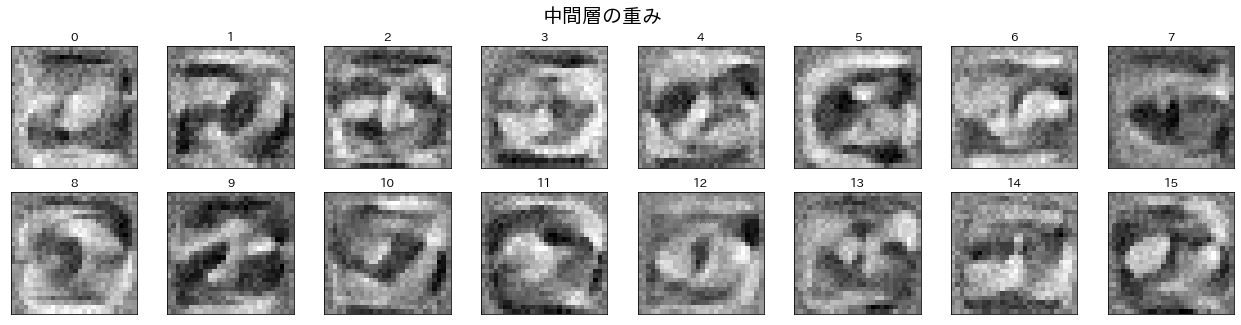

In [ ]:
# show_weight関数の実行


それぞれのニューロンが、画像から異なる特徴を抽出しようとしている様子が伺えます。

# 発展1：ReLU関数

この節では、中間層の活性化関数として、ReLU関数を使用してみます。

## ネットワークの作成

In [ ]:
# 乱数シード値の固定


# 系列モデルをインスタンス化


# モデルに（中間）層を追加　＊活性化関数にReLU関数を指定


# モデルに（出力）層を追加


# 学習プロセスを設定


## 学習

In [ ]:
# 学習を実行


Epoch 1/10
60/60 [==============================] - 1s 8ms/step - loss: 1.4999 - accuracy: 0.5611 - val_loss: 0.8689 - val_accuracy: 0.7881
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6784 - accuracy: 0.8305 - val_loss: 0.5259 - val_accuracy: 0.8676
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.4742 - accuracy: 0.8770 - val_loss: 0.4109 - val_accuracy: 0.8937
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3931 - accuracy: 0.8958 - val_loss: 0.3558 - val_accuracy: 0.9064
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3490 - accuracy: 0.9058 - val_loss: 0.3242 - val_accuracy: 0.9130
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3205 - accuracy: 0.9120 - val_loss: 0.3028 - val_accuracy: 0.9180
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3012 - accuracy: 0.9168 - val_loss: 0.2885 - val_accuracy: 0.9200
Epoch 8/10
60/60 [==

## 予測結果と評価指標

In [ ]:
# モデルをテストデータで評価


# 誤差の表示


# 正答率の表示


Loss: 0.260837
Accuracy: 0.9259


活性化関数をシグモイド関数からReLU関数に変更することで、Loss, Accuracy共に、改善が見られました。

不正解の画像数は1000枚から700枚程度に減少したことでしょう。

## モデルの予測結果の図示

<Figure size 432x288 with 0 Axes>

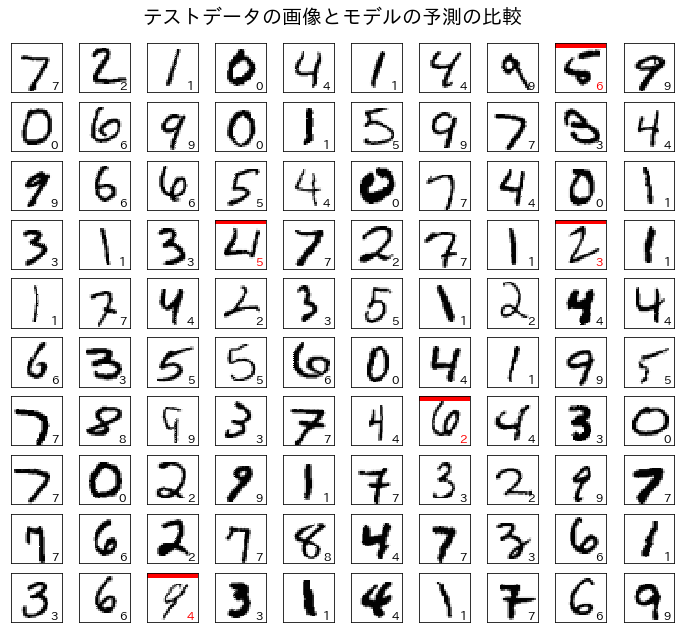

視覚的にも、改善の様子がみて取れます。

## 重みを図示

<Figure size 432x288 with 0 Axes>

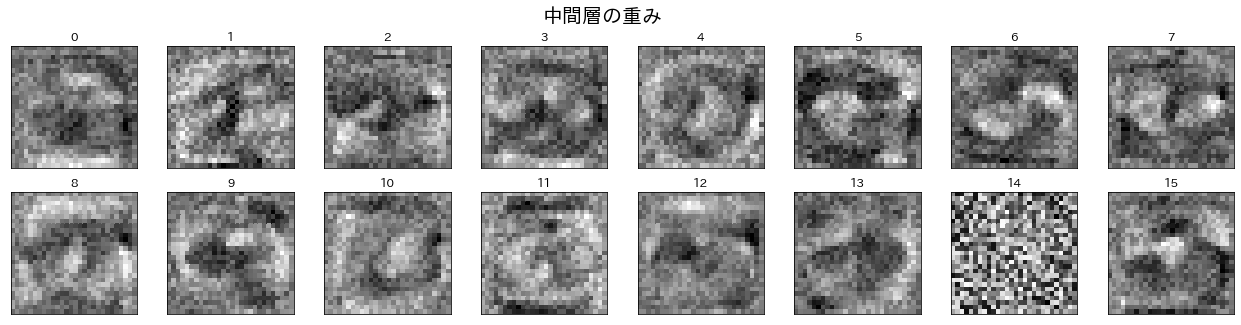

重みの様子にも変化が現れました。

# 発展2：畳み込みニューラルネットワーク

この章では、畳み込みニューラルネットワーク（Convolutional Neural Network: CNN）による学習を行います。

これまでのニューラルネットワークでは、画像を一次元配列のデータとして入力層のニューロンに渡していました。この場合、同じ数字の画像でも、少しずれた画像になると、精度良く画像を識別できない問題点があります。また、数字の特徴を示すと考えられる、隣接したピクセル同士の情報も、ネットワークの構造としては考慮されていませんでした。

このような問題点を解決する手法として、空間フィルターを用いた畳み込み演算があります。この方法を用いると、位置のズレに強いモデルや、縦線や横線など、図形の特徴をうまく捉えるネットワークが構築できるというメリットがあります。




## 畳み込み演算とは

畳み込み演算では、数ピクセルサイズの空間フィルタ（一般には3×3や5×5）と画像のピクセル値との積和演算を繰り返します。



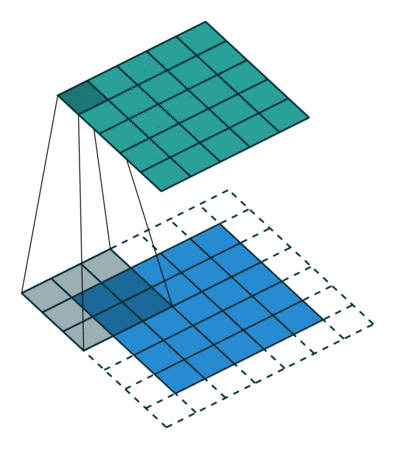

In [ ]:
Image('fig/Convolution_arithmetic_Same_padding_no_strides.gif', width=300, format='png')

上の図において、底面の青い領域が入力画像、入力画像上を動く灰色の領域が空間フィルタ、上面の緑色の領域が、各空間フィルタの配置における、フィルタと画像のピクセル値の積和計算結果になります。

なお、フィルタのピクセル値は、画像との積和計算の過程では固定した値を使用します。

畳み込み演算の意味について、具体例で考えてみましょう。

仮に、ある空間フィルタのピクセル値が次のような横方向の構造を思った値を取るとします。

||||
|:-:|:-:|:-:|
|-1|-1|-1|
|2|2|2|
|-1|-1|-1|

この時、フィルタと重なる画像のピクセル値が、以下のように図形としての構造を持たないような部分だったとすると、

||||
|:-:|:-:|:-:|
|0.3|0.3|0.3|
|0.3|0.3|0.4|
|0.3|0.3|0.3|

空間フィルタとの積和計算の結果は0に（近く）なります。

0.3x(-1)+0.3x(-1)+0.4x(-1) <br>
+0.3x(2)+0.3x(2)+0.3x(2) <br>
+0.3x(-1)+0.3x(-1)+0.3x(-1) <br>
= (-1.0) + (1.8) + (-0.9) <br>
= -0.1

一方で、空間フィルタと重なる画像のピクセル値にも、横方向の構造があったとすると、

||||
|:-:|:-:|:-:|
|0.3|0.3|0.3|
|0.6|0.6|0.6|
|0.3|0.3|0.3|

この時の積和の計算は0からずれた値になります。

0.3x(-1)+0.3x(-1)+0.3x(-1) <br>
+0.6x(2)+0.6x(2)+0.6x(2) <br>
+0.3x(-1)+0.3x(-1)+0.3x(-1) <br>
= (-0.9) + (3.6) + (-0.9) <br>
= 1.8


このように、畳み込み演算では、画像の中に空間フィルタと似た構造を持つ部分の出力（の絶対値）値が大きくなる特徴があります。

なお、先の例では横方向の特徴をもった空間フィルタを人為的に考えましたが、畳み込みニューラルネットワークでは、空間フィルタの値はこれまでのシナプス結合の重みと同様に、ネットワーク自身が学習することになります。

その結果については、章の終わりに確認します。

因みに、畳み込み演算をそのまま行うと、入力画像のサイズに対して、出力画像のサイズは一般に小さくなります。

これを防ぐには、上図にあるように、元画像の周囲にセルを追加して、畳み込みの前後で画像サイズが変わらないように調整します。これは``padding``（詰め物の意）と呼ばれます。

## データの前処理

ネットワークを構成する前に、これまで一次元配列にしていた画像のデータを、元の28×28の形に戻します。

((60000, 784), (10000, 784))

((60000, 28, 28, 1), (10000, 28, 28, 1))

## ネットワークの作成

ここでは、畳み込みニューラルネットワークを以下の流れで作成します。

- 学習結果の再現性を確保するために、計算過程で使用する乱数のシード値を任意の値で固定します。

- Sequentialクラスをインスタンス化し、系列モデルを作成します。

- モデルに畳み込み層を(クラスをインスタンス化して)を追加します。
  - 初めの位置引数は、空間フィルタの枚数です。今回は8にします。
  - 次の位置引数は空間フィルタのサイズです。今回は3×3にします。
  - ``padding``は``same``とすることで、出力サイズが変わらないようにパディングが追加されます。
  - ``input_shape``は入力画像サイズのことで、最後の値は白黒画像で1、RGB画像で3を指定します。
  - ``activation``は活性化関数で、ReLU関数を使用します。

- モデルにFlattenを追加して、畳み込み後の出力層への入力平坦化します。
  - 8枚の空間フィルタによる畳み込み演算では、各フィルタに対してそれぞれ28×28の出力がありますが、この部分（8×28×28）を直列に変換します。

- モデルに出力層を(クラスをインスタンス化して)を追加します。
  - 10は出力層のユニット（ニューロン）数です。
  - ``activation``は活性化関数で、ソフトマックス関数を使用します。

- 訓練プロセスを設定します。

In [ ]:
from keras.layers import Conv2D
from keras.layers import Flatten

In [ ]:
# 乱数シード値の固定


# 系列モデルをインスタンス化


# モデルに畳み込み層を追加


# 入力を平坦化


# モデルに（出力）層を追加


# 学習プロセスを設定


## 学習

今回の処理では、学習にかかった時間も計測してみます。（GCPのデフォルトのインスタンスを使用した場合、5分弱かかります。）

In [ ]:
import time

# 開始時刻を保存


# 学習を開始


# 終了時刻を保存


Epoch 1/20
60/60 [==============================] - 2s 18ms/step - loss: 0.8354 - accuracy: 0.7982 - val_loss: 0.3542 - val_accuracy: 0.8995
Epoch 2/20
60/60 [==============================] - 1s 14ms/step - loss: 0.3240 - accuracy: 0.9075 - val_loss: 0.2788 - val_accuracy: 0.9217
Epoch 3/20
60/60 [==============================] - 1s 14ms/step - loss: 0.2678 - accuracy: 0.9239 - val_loss: 0.2381 - val_accuracy: 0.9331
Epoch 4/20
60/60 [==============================] - 1s 13ms/step - loss: 0.2265 - accuracy: 0.9362 - val_loss: 0.2038 - val_accuracy: 0.9422
Epoch 5/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1948 - accuracy: 0.9456 - val_loss: 0.1808 - val_accuracy: 0.9507
Epoch 6/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1681 - accuracy: 0.9537 - val_loss: 0.1574 - val_accuracy: 0.9572
Epoch 7/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1490 - accuracy: 0.9591 - val_loss: 0.1426 - val_accuracy: 0.9617
Epoch 8/20
60

実行時間を表示

Computation time: 21.0 sec


## 予測結果と評価指標

In [ ]:
# モデルをテストデータで評価


# 誤差の表示


# 正答率の表示


Loss: 0.078516
Accuracy: 0.9761


不正解の画像数は700枚から300枚程度にまで減少したことでしょう。

## モデルの予測結果の図示

モデルの予測結果を図示してみましょう。

<Figure size 432x288 with 0 Axes>

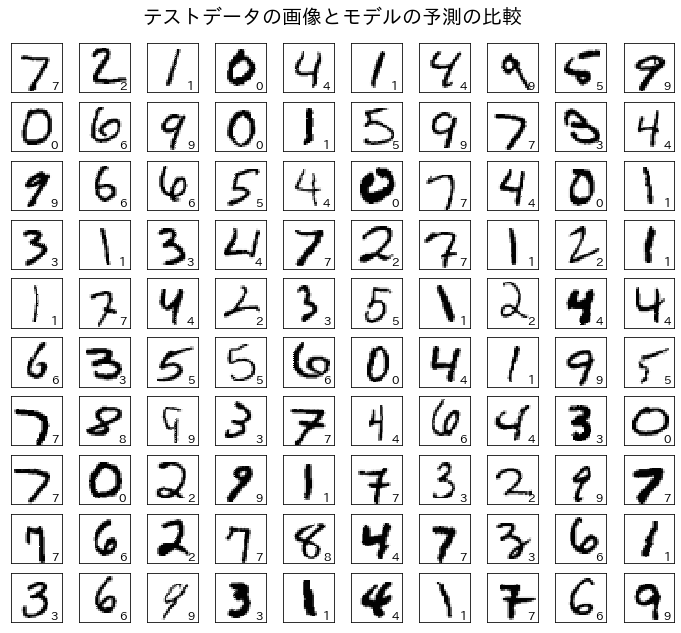

誤認識されたのは、かなり潰れた手書き文字だけになりました。

## 重みを図示

最後に、フィルタの重みを図示してみます。

<Figure size 432x288 with 0 Axes>

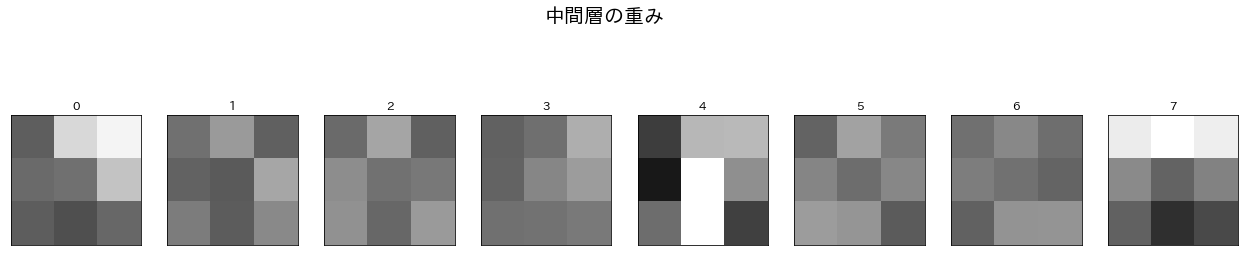

In [ ]:
# カラーマップをgrayに設定


# 2行8列のAxesを持つFigureを生成


# Figureのタイトルを設定


# Figureのタイトルの位置を調節


#　中間層の重みを取得


# 重みの最小値を取得


# 重みの最大値を取得


# ループ処理を開始


  # 重みデータを取得


  # 重みを表示


  # 重みの番号をタイトルに表示


  # 縦軸の表示範囲を（反転して）設定


  # x軸に関する情報を非表示


  # y軸に関する情報を非表示


  # アスペクト比を揃える


# 結果を表示


図から、各フィルタが縦線や横線、折れ曲がりの構造を捉えようとしていることが見て取れます。（＊実行結果には差異があります。）

# まとめ

この資料では、ディープラーニングの手法を用いて、手書き数字の画像データの分類問題に取り組みました。

今回は基本的な手法のみ紹介しましたが、画像認識にはプーリングやドロップアウトなど、他にも様々な手法があります。興味がある人はこれらを実装したり、層やユニット数を変えたりしながら、是非いろいろと試してみてください。

また、ディープラーニングが発展した背景には、インターネットの発達によって多くの学習データが得られるようになったこと、またGPUなどによって行列計算を高速に行えるようになったことがあります。

Google Colaboratoryでは、ランタイム＞ランタイムのタイプから、「ハードウェア アクセラレータ」を「GPU」に変更することができます。その場合に、発展2の学習時間がどれぐらい短縮されるか、是非試してみてください。


# 参考資料

- THE MNIST DATABASE of handwritten digits <br/>
http://yann.lecun.com/exdb/mnist/

- 画像: Artificial neural network <br/>
https://en.wikipedia.org/wiki/Artificial_neural_network

-  Keras<br/>
https://keras.io/ja/

- 画像: github.com/vdumoulin/conv_arithmetic <br/>
https://github.com/vdumoulin/conv_arithmetic


- Pythonで動かして学ぶ！あたらしい機械学習の教科書　第2版
  - 著者：伊藤真
  - 出版社：翔泳社 (2019/9/18)

- ゼロから作るDeep LearningーPythonで学ぶディープラーニングの理論と実装
  - 著者：斎藤康毅
  - 出版社：オライリージャパン (2016/9/24)

東京みらい AI＆IT 専門学校